In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import scanpy as sc
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

def set_axis_style(ax, labels):
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel('Sample name')

In [2]:
import scarches
from scarches.dataset import remove_sparsity
from tranvae.model import TRANVAE

In [3]:
adata = sc.read(os.path.expanduser(
    f'~/Documents/benchmarking_datasets/benchmark_pancreas_shrinked.h5ad'
))
adata

AnnData object with n_obs × n_vars = 16382 × 4000
    obs: 'study', 'cell_type'

In [4]:
condition_key = "study"
cell_type_keys = ["cell_type"]

reference = ["inDrop1", "inDrop2", "inDrop3", "inDrop4", 
             "fluidigmc1", "smartseq2", "smarter"]
query = ["celseq", "celseq2"]

In [5]:
adata = remove_sparsity(adata)
ref_adata = adata[adata.obs.study.isin(reference)].copy()
query_adata = adata[adata.obs.study.isin(query)].copy()

In [6]:
cells_per_ct = 500
cell_type_key = "cell_type"

indices = np.arange(len(ref_adata))
labeled_ind = []
cts = ref_adata.obs[cell_type_key].unique().tolist()
for celltype in cts:
    ct_indices = indices[ref_adata.obs[cell_type_key].isin([celltype])]
    ct_sample_size = cells_per_ct
    if cells_per_ct > len(ct_indices):
        ct_sample_size = len(ct_indices)
    ct_sel_ind = np.random.choice(
        ct_indices, 
        size=ct_sample_size, 
        replace=False
    )
    labeled_ind += ct_sel_ind.tolist()
    print(celltype, len(ct_indices), len(ct_sel_ind), len(labeled_ind))

gamma 571 500 500
acinar 1167 500 1000
alpha 4459 500 1500
delta 802 500 2000
beta 3563 500 2500
ductal 1557 500 3000
endothelial 287 287 3287
activated_stellate 355 355 3642
schwann 20 20 3662
mast 35 35 3697
macrophage 63 63 3760
epsilon 27 27 3787
quiescent_stellate 180 180 3967
t_cell 7 7 3974


# Semi-supervised Pipeline

In [7]:
tranvae = TRANVAE(
    adata=ref_adata,
    condition_key=condition_key,
    cell_type_keys=cell_type_keys,
    hidden_layer_sizes=[128, 128],
    labeled_indices=labeled_ind,
    unknown_ct_names=['delta']
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 4000 128 7
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 7
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 4000 



In [8]:
early_stopping_kwargs = {
    "early_stopping_metric": "val_classifier_loss",
    "mode": "min",
    "threshold": 0,
    "patience": 20,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}

tranvae.train(
    n_epochs=500,
    early_stopping_kwargs=early_stopping_kwargs,
    pretraining_epochs=100,
    alpha_epoch_anneal=1e6,
    eta=1,
    unlabeled_weight=0.001,
    clustering_res=2,
)

 |████----------------| 20.0%  - val_loss: 1004.2366111062 - val_trvae_loss: 1004.2366111062
Initializing unlabeled landmarks with Leiden-Clustering with an unknown number of clusters.
Leiden Clustering succesful. Found 33 clusters.
 |██████--------------| 32.6%  - val_loss: 1005.3332852450 - val_trvae_loss: 1004.7902388139 - val_classifier_loss: 0.5430530120 - val_unlabeled_loss: 1.5701097467 - val_labeled_loss: 0.5414829037
ADJUSTED LR
 |████████------------| 44.0%  - val_loss: 1004.0599032315 - val_trvae_loss: 1003.6597345526 - val_classifier_loss: 0.4001669667 - val_unlabeled_loss: 1.0553645112 - val_labeled_loss: 0.3991116041
ADJUSTED LR
 |█████████-----------| 45.4%  - val_loss: 1001.8060080788 - val_trvae_loss: 1001.4128196023 - val_classifier_loss: 0.3931895305 - val_unlabeled_loss: 1.0435498086 - val_labeled_loss: 0.3921459805
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different para

### Evaluation after reference training

In [9]:
unlabeled_ind = np.delete(indices, labeled_ind).tolist()

In [10]:
results_dict = tranvae.classify(
    ref_adata[unlabeled_ind].X,
    ref_adata[unlabeled_ind].obs[condition_key],
)
preds = results_dict[cell_type_key]['preds']
probs = results_dict[cell_type_key]['probs']
print(classification_report(
    y_true=ref_adata[unlabeled_ind].obs[cell_type_key],
    y_pred=preds,
    labels=np.array(ref_adata[unlabeled_ind].obs[cell_type_key].unique().tolist())
))

              precision    recall  f1-score   support

       gamma       0.70      1.00      0.83        71
      acinar       0.83      0.97      0.89       667
       alpha       1.00      0.98      0.99      3959
       delta       0.00      0.00      0.00       302
        beta       0.99      0.99      0.99      3063
      ductal       0.99      0.89      0.94      1057

   micro avg       0.98      0.94      0.96      9119
   macro avg       0.75      0.81      0.77      9119
weighted avg       0.95      0.94      0.94      9119



/home/marco/.pyenv/versions/tranvae/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/marco/.pyenv/versions/tranvae/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/marco/.pyenv/versions/tranvae/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

In [11]:
results_dict = tranvae.classify()
preds = results_dict[cell_type_key]['preds']
probs = results_dict[cell_type_key]['probs']
print(classification_report(
    y_true=ref_adata.obs[cell_type_key],
    y_pred=preds,
    labels=np.array(ref_adata.obs[cell_type_key].unique().tolist())
))

                    precision    recall  f1-score   support

             gamma       0.92      1.00      0.96       571
            acinar       0.87      0.98      0.92      1167
             alpha       1.00      0.99      0.99      4459
             delta       0.00      0.00      0.00       802
              beta       0.98      0.99      0.98      3563
            ductal       0.99      0.90      0.94      1557
       endothelial       0.99      0.98      0.98       287
activated_stellate       0.97      0.98      0.97       355
           schwann       0.95      1.00      0.98        20
              mast       0.85      0.97      0.91        35
        macrophage       0.97      1.00      0.98        63
           epsilon       0.04      0.96      0.07        27
quiescent_stellate       0.85      0.97      0.91       180
            t_cell       0.19      0.86      0.31         7

          accuracy                           0.92     13093
         macro avg       0.75      0.9

/home/marco/.pyenv/versions/tranvae/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/marco/.pyenv/versions/tranvae/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/marco/.pyenv/versions/tranvae/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

In [12]:
labeled_set = tranvae.get_landmarks_info()
labeled_set

AnnData object with n_obs × n_vars = 13 × 10
    obs: 'study', 'cell_type', 'cell_type_pred', 'cell_type_prob'

In [13]:
unlabeled_set = tranvae.get_landmarks_info(landmark_set='u')
unlabeled_set

AnnData object with n_obs × n_vars = 33 × 10
    obs: 'study', 'cell_type', 'cell_type_pred', 'cell_type_prob'

In [15]:
data_latent = tranvae.get_latent()
adata_latent = sc.AnnData(data_latent)
adata_latent.obs[condition_key] = ref_adata.obs[condition_key].tolist()
adata_latent.obs[cell_type_key] = ref_adata.obs[cell_type_key].tolist()
adata_latent.obs[f'{cell_type_key}_pred'] = preds.tolist()
adata_latent.obs[f'{cell_type_key}_prob'] = probs.tolist()
adata_latent

AnnData object with n_obs × n_vars = 13093 × 10
    obs: 'study', 'cell_type', 'cell_type_pred', 'cell_type_prob'

In [16]:
full_latent = adata_latent.concatenate(labeled_set, unlabeled_set)
full_latent

AnnData object with n_obs × n_vars = 13139 × 10
    obs: 'study', 'cell_type', 'cell_type_pred', 'cell_type_prob', 'batch'

In [17]:
sc.pp.neighbors(full_latent, n_neighbors=8)
sc.tl.leiden(full_latent)
sc.tl.umap(full_latent)

/home/marco/.pyenv/versions/tranvae/lib/python3.7/site-packages/anndata/_core/anndata.py:1229: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'study' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cell_type' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cell_type_pred' as categorical


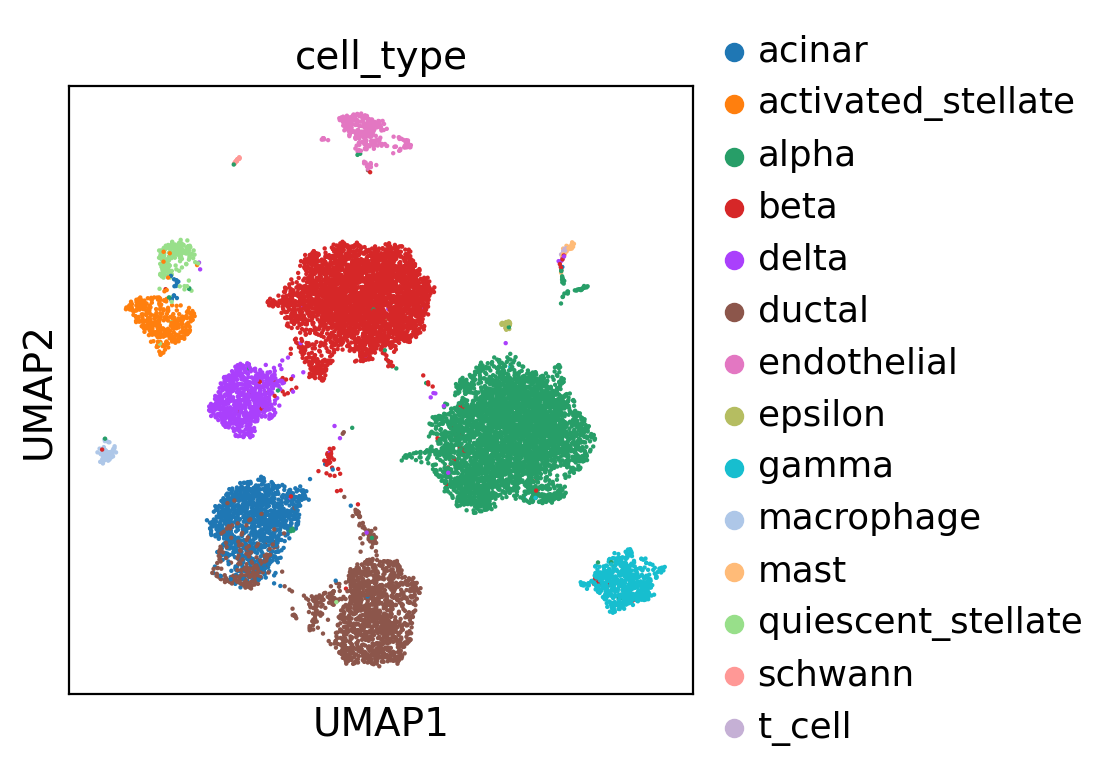

In [18]:
landmark_keys = ["Landmark-Set Unlabeled","Landmark-Set Labeled"]
sc.pl.umap(
    full_latent[~full_latent.obs[condition_key].isin(landmark_keys)],
    size=10,
    color=[cell_type_key],
)

### Visualization of Landmarks in UMAP

Labeled set of landmarks:

... storing 'study' as categorical
... storing 'cell_type' as categorical
... storing 'cell_type_pred' as categorical
Trying to set attribute `.uns` of view, copying.


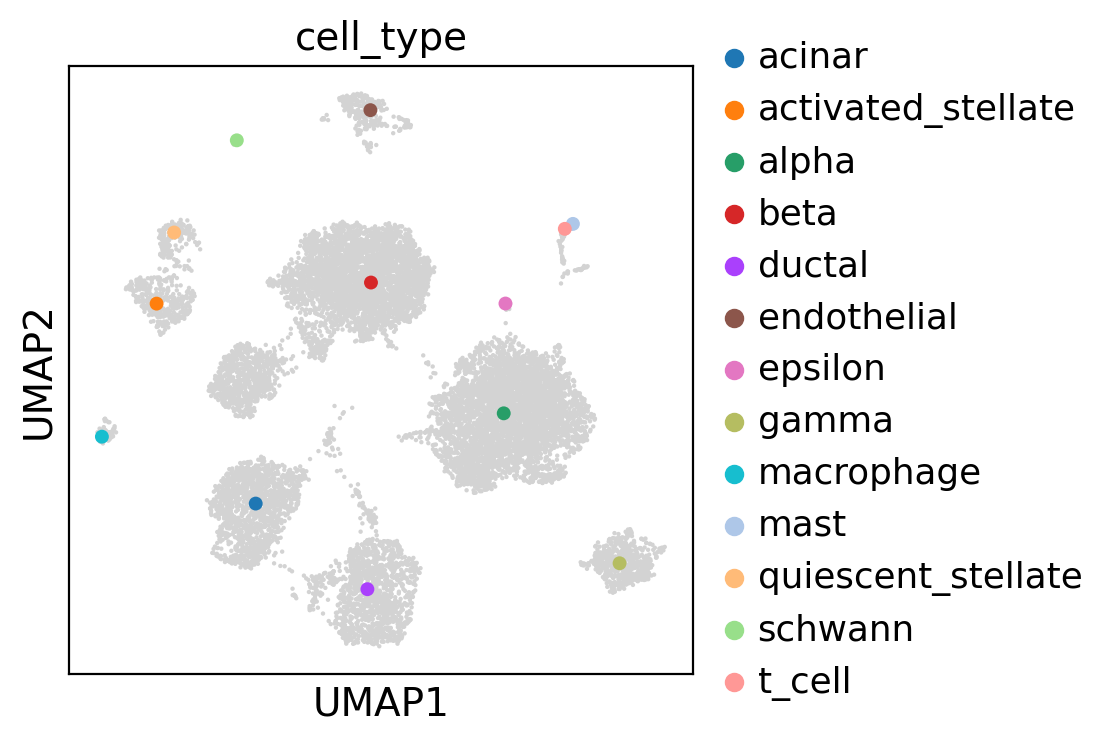

In [19]:
ax = sc.pl.umap(full_latent, size=10, show=False)
sc.pl.umap(
    full_latent[full_latent.obs[condition_key] == "Landmark-Set Labeled"],
    size=100,
    color=[cell_type_key],
    ax=ax
)

Unlabeled set of landmarks:

Trying to set attribute `.uns` of view, copying.


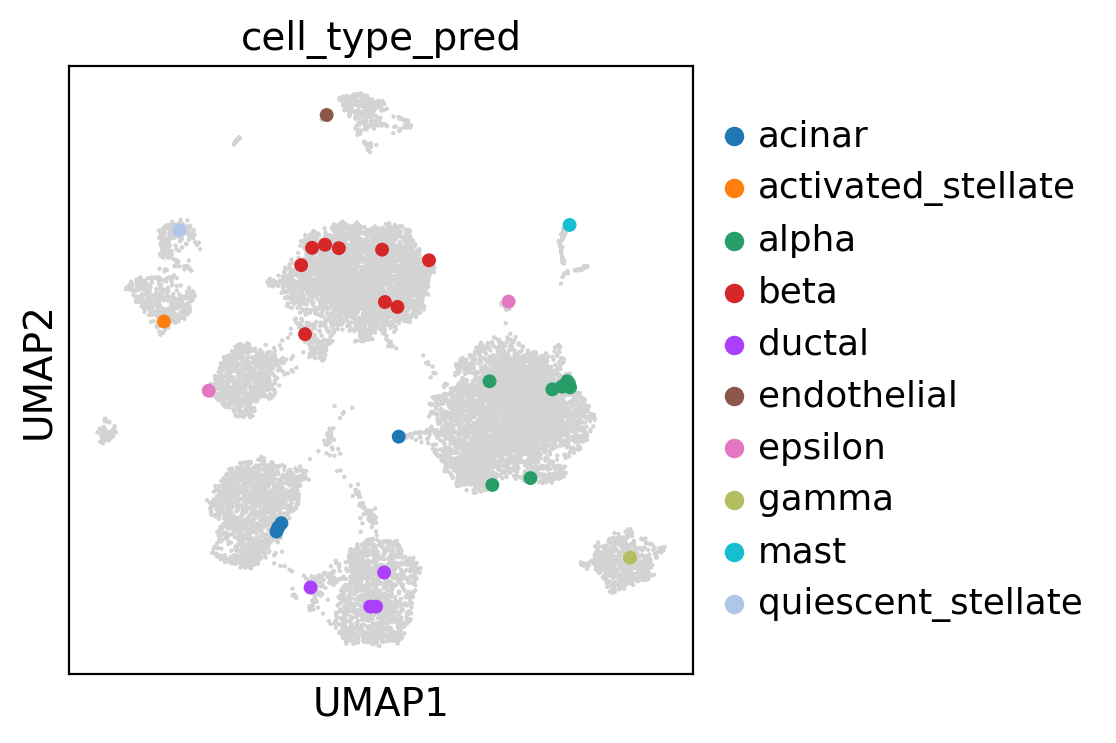

In [20]:
ax = sc.pl.umap(full_latent, size=10, show=False)
sc.pl.umap(
    full_latent[full_latent.obs[condition_key] == "Landmark-Set Unlabeled"],
    size=100,
    color=[cell_type_key + '_pred'],
    ax=ax
)

In [21]:
x = exiting
unlabeled_set.obs[cell_type_key + '_pred'] == "epsilon"

0     False
1     False
2      True
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24    False
25    False
26    False
27    False
28    False
29    False
30    False
31    False
32     True
Name: cell_type_pred, dtype: bool

In [22]:
tranvae.add_new_cell_type("delta", cell_type_key, [2])

In [25]:
results_dict = tranvae.classify()
preds = results_dict[cell_type_key]['preds']
probs = results_dict[cell_type_key]['probs']
print(classification_report(
    y_true=ref_adata.obs[cell_type_key],
    y_pred=preds,
    labels=np.array(ref_adata.obs[cell_type_key].unique().tolist())
))

                    precision    recall  f1-score   support

             gamma       0.91      1.00      0.95       571
            acinar       0.86      0.98      0.92      1167
             alpha       1.00      0.98      0.99      4459
             delta       0.00      0.00      0.00       802
              beta       0.98      0.99      0.98      3563
            ductal       0.99      0.90      0.94      1557
       endothelial       0.99      0.98      0.98       287
activated_stellate       0.96      0.97      0.96       355
           schwann       0.95      1.00      0.98        20
              mast       0.87      0.97      0.92        35
        macrophage       0.95      1.00      0.98        63
           epsilon       0.04      0.96      0.07        27
quiescent_stellate       0.84      0.97      0.90       180
            t_cell       0.19      1.00      0.33         7

          accuracy                           0.91     13093
         macro avg       0.75      0.9

/home/marco/.pyenv/versions/tranvae/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/marco/.pyenv/versions/tranvae/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/marco/.pyenv/versions/tranvae/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

In [26]:
labeled_set = tranvae.get_landmarks_info()
unlabeled_set = tranvae.get_landmarks_info(landmark_set='u')
labeled_set

AnnData object with n_obs × n_vars = 14 × 10
    obs: 'study', 'cell_type', 'cell_type_pred', 'cell_type_prob'

In [28]:
data_latent = tranvae.get_latent()
adata_latent = sc.AnnData(data_latent)
adata_latent.obs[condition_key] = ref_adata.obs[condition_key].tolist()
adata_latent.obs[cell_type_key] = ref_adata.obs[cell_type_key].tolist()
adata_latent.obs[f'{cell_type_key}_pred'] = preds.tolist()
adata_latent.obs[f'{cell_type_key}_prob'] = probs.tolist()
full_latent = adata_latent.concatenate(labeled_set, unlabeled_set)

AnnData object with n_obs × n_vars = 13093 × 10
    obs: 'study', 'cell_type', 'cell_type_pred', 'cell_type_prob'

In [30]:
sc.pp.neighbors(full_latent, n_neighbors=8)
sc.tl.leiden(full_latent)
sc.tl.umap(full_latent)

/home/marco/.pyenv/versions/tranvae/lib/python3.7/site-packages/anndata/_core/anndata.py:1229: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'study' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cell_type' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cell_type_pred' as categorical


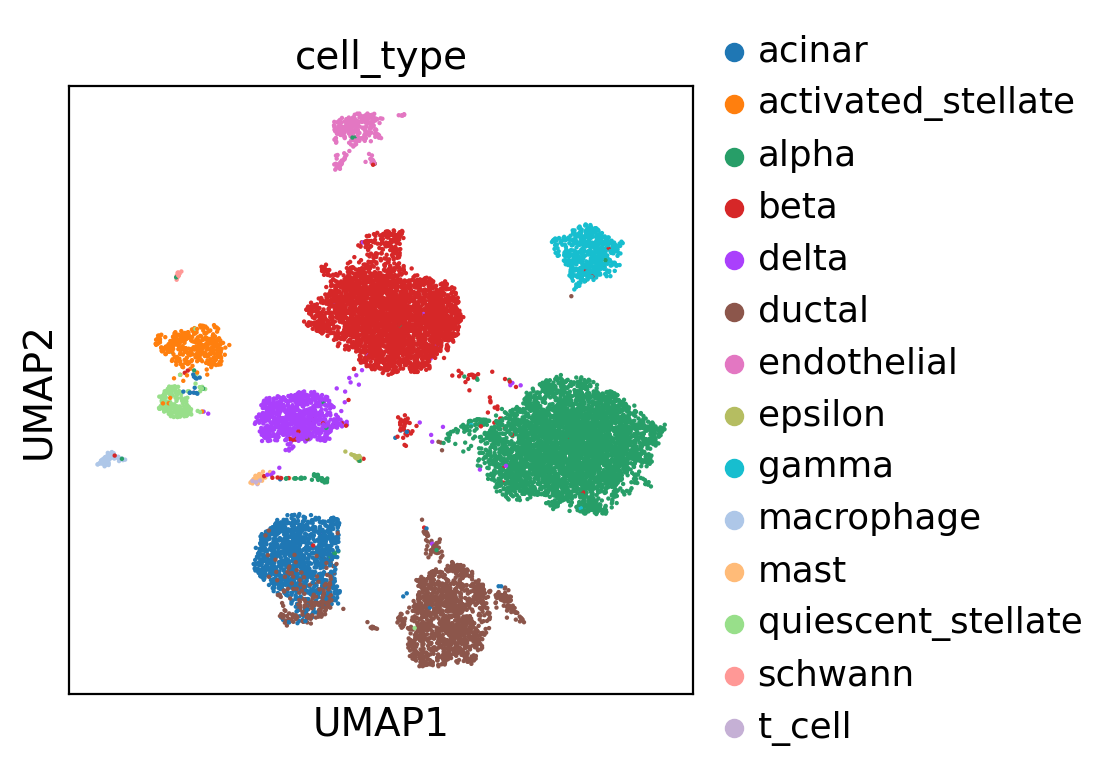

In [31]:
landmark_keys = ["Landmark-Set Unlabeled","Landmark-Set Labeled"]
sc.pl.umap(
    full_latent[~full_latent.obs[condition_key].isin(landmark_keys)],
    size=10,
    color=[cell_type_key],
)

... storing 'study' as categorical
... storing 'cell_type' as categorical
... storing 'cell_type_pred' as categorical
Trying to set attribute `.uns` of view, copying.


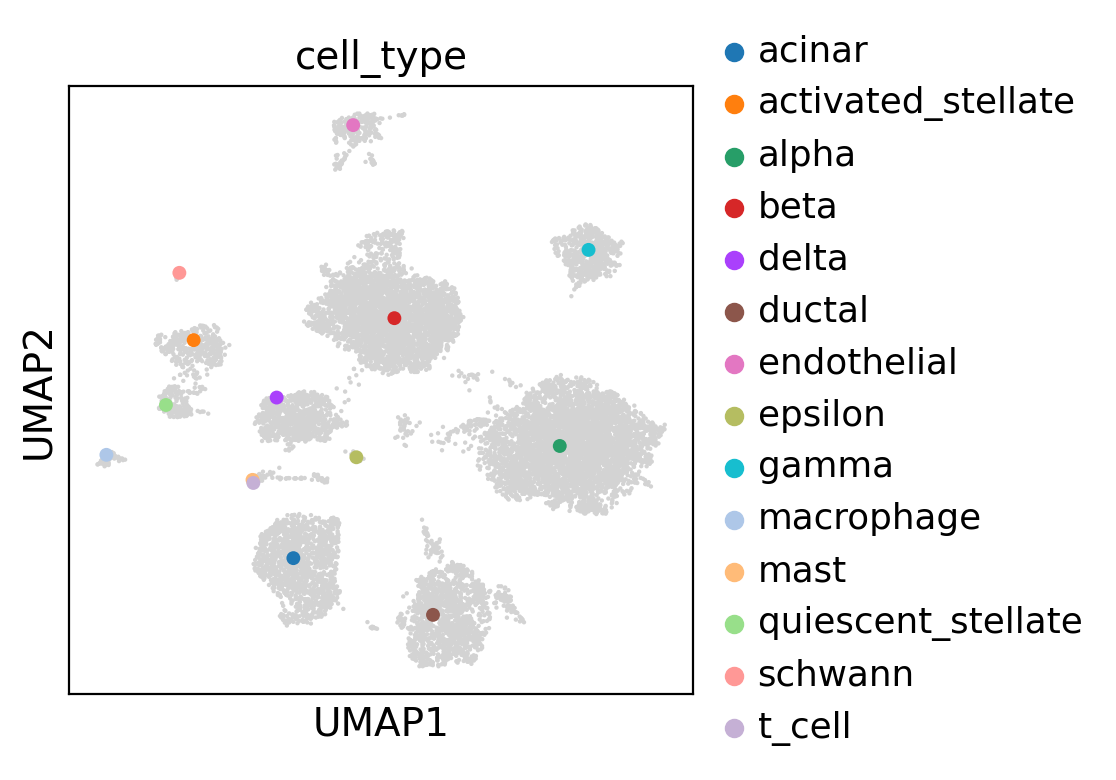

In [32]:
ax = sc.pl.umap(full_latent, size=10, show=False)
sc.pl.umap(
    full_latent[full_latent.obs[condition_key] == "Landmark-Set Labeled"],
    size=100,
    color=[cell_type_key],
    ax=ax
)